In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import diags

def create_fixed_degree_network(num_nodes_x, num_nodes_y, degree_x, degree_y,seed=None):

    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    # Define degree sequence
    degree_sequence = [degree_x] * num_nodes_x + [degree_y] * num_nodes_y

    # Check if the sum of degrees is even
    if sum(degree_sequence) % 2 != 0:
        raise ValueError("The sum of degrees must be even to form a valid graph.")

    # Generate a random graph using the configuration model
    G = nx.configuration_model(degree_sequence)

    # Convert the multigraph to a simple graph (remove parallel edges and self-loops)
    G = nx.Graph(G)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

def create_fixed_degree_network_v2(num_nodes_x, num_nodes_y, degree_x, degree_y, seed=None):
    """
    Creates a fixed degree network with the specified parameters, ensuring the graph is a single connected component.

    Parameters:
    - num_nodes_x (int): Number of nodes of type X.
    - num_nodes_y (int): Number of nodes of type Y.
    - degree_x (int): Degree of each node of type X.
    - degree_y (int): Degree of each node of type Y.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - G (networkx.Graph): A simple, connected graph with the specified degree sequence.
    """
    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    # Define degree sequence
    degree_sequence = [degree_x] * num_nodes_x + [degree_y] * num_nodes_y

    # Check if the sum of degrees is even
    if sum(degree_sequence) % 2 != 0:
        raise ValueError("The sum of degrees must be even to form a valid graph.")
    
    while True:
        # Generate a random graph using the configuration model
        G = nx.configuration_model(degree_sequence)

        # Convert the multigraph to a simple graph (remove parallel edges and self-loops)
        G = nx.Graph(G)
        G.remove_edges_from(nx.selfloop_edges(G))

        # Check if the graph is connected
        if nx.is_connected(G):
            return G

# Generate a random graph using the Erdős-Rényi model
def erdos_renyi_graph(num_nodes,probability):
    graph = nx.erdos_renyi_graph(n=num_nodes, p=probability)

    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)
    return graph

#watts_strogarz model (small-world)
def watts_strogarz_graph(n,k,p):
    graph = nx.watts_strogatz_graph(n,k,p,seed=100)

    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)

    return graph

#scale free networks
def barabasi_albert_graph(n,m):

    graph = nx.barabasi_albert_graph(n,m,seed=100)
   
    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)
    
    return graph

#stochastic_block_model
def stochastic_block_model(sizes, probs):

    graph = nx.stochastic_block_model(sizes, probs, seed=100)
   
    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)
    
    return graph

In [2]:
graph = stochastic_block_model([10,10,10],
                               [[0.8,0.2,0.2],[0.2,0.8,0.2],[0.2,0.2,0.8]])

#graph = watts_strogarz_graph(100,2,0.5)

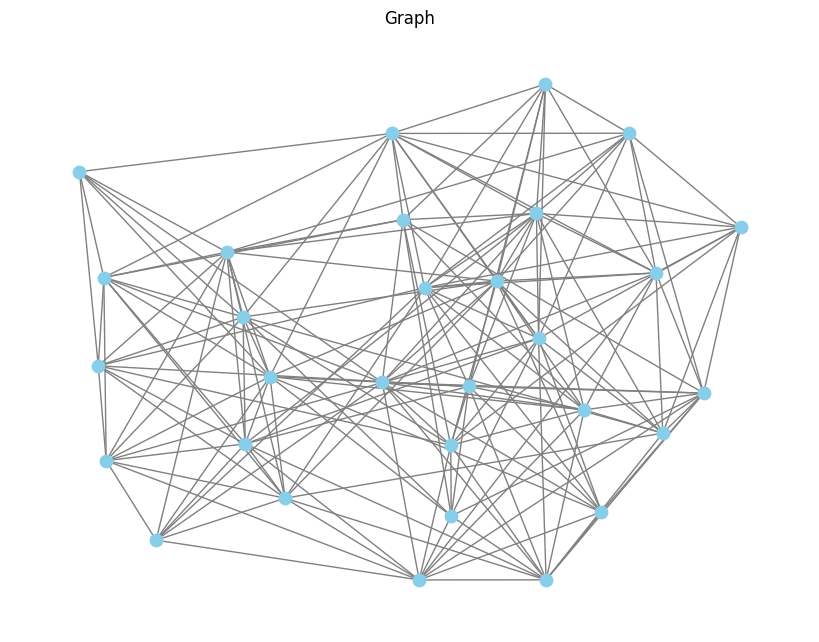

connected components: 1


In [3]:
# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=80, font_size=10)
plt.title("Graph")
plt.show()

print("connected components: "+str(nx.number_connected_components(graph)))

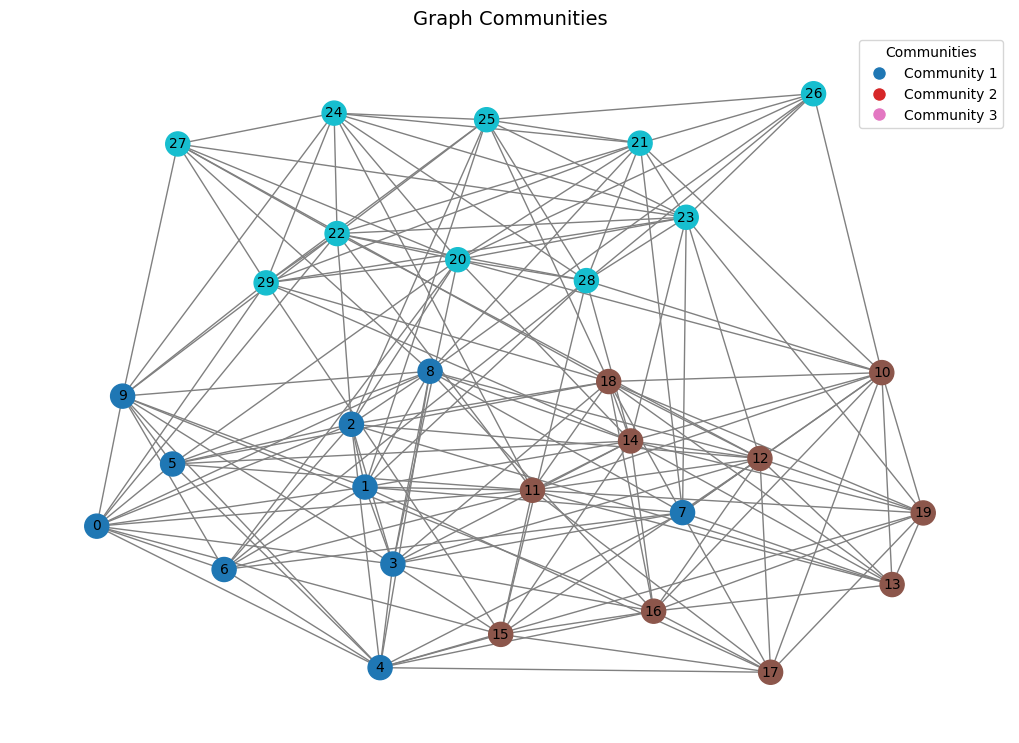

In [4]:
#Community Deteccion

communities = list(nx.algorithms.community.louvain_communities(graph))

def plot_communities(graph, communities):

    #Assign community numbers to nodes
    community_mapping = {}
    for i, community in enumerate(communities):
        for node in community:
            community_mapping[node] = i
    
    # Step 4: Prepare node colors based on communities
    colors = [community_mapping[node] for node in graph.nodes()]
    
    # Step 5: Draw the graph with communities
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(graph, seed=42)  # Layout for consistent visualization
    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_color=colors,
        node_size=300,
        cmap=plt.cm.tab10,  # Use a colormap for community coloring
        edge_color="gray",
        font_size=10,
    )
    # Add community labels to the legend
    handles = []
    for i, community in enumerate(communities):
        handle = plt.Line2D([0], [0], marker='o', color='w', label=f'Community {i+1}', 
                             markersize=10, markerfacecolor=plt.cm.tab10(i / len(communities)))
        handles.append(handle)
    
    plt.legend(handles=handles, title="Communities", loc="upper right")
    plt.title("Graph Communities", fontsize=14)
    plt.show()


plot_communities(graph, communities)

In [5]:
#measure of centrality (betweeness centrality)

centrality = nx.betweenness_centrality(graph, k=None, normalized=True, weight=None, endpoints=False, seed=100)

#centrality for every community

# Calculate average betweenness centrality for each community
community_averages = []
for community in communities:
    centrality_sum = sum(centrality[node] for node in community if node in centrality)
    community_size = len(community)
    average_centrality = centrality_sum / community_size
    community_averages.append(average_centrality)

# Display results
for i, avg in enumerate(community_averages):
    print(f"Community {i+1}: Average Betweenness Centrality = {avg:.4f}")

Community 1: Average Betweenness Centrality = 0.0216
Community 2: Average Betweenness Centrality = 0.0242
Community 3: Average Betweenness Centrality = 0.0185


In [6]:
communities

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 {10, 11, 12, 13, 14, 15, 16, 17, 18, 19},
 {20, 21, 22, 23, 24, 25, 26, 27, 28, 29}]

In [7]:
# Get the adjacency matrix
adj_matrix = nx.adjacency_matrix(graph).toarray()

# Compute the Laplacian matrix
laplacian_matrix = nx.laplacian_matrix(graph).tocsc()

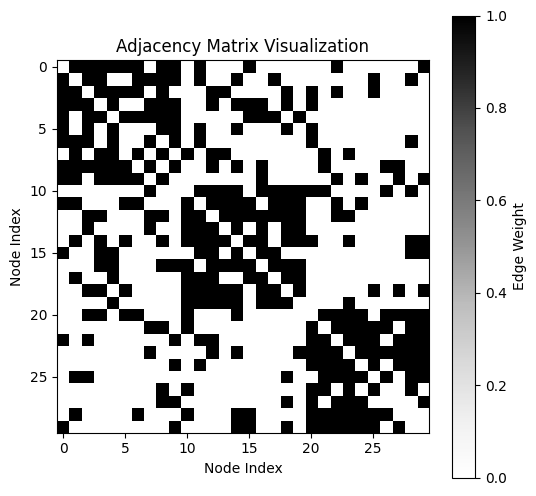

In [8]:
# Visualize the adjacency matrix as a lattice
plt.figure(figsize=(6, 6))
plt.imshow(adj_matrix, cmap='Greys', interpolation='none')
plt.colorbar(label="Edge Weight")
plt.title("Adjacency Matrix Visualization")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

In [9]:
def RK4_FD(eq, fields, parameters, grids, dt, Nt, operators, t_rate): #implementa rouge-kutta
    t_grid = grids[0]
    x_grid = grids[1]
    y_grid = grids[2]
    fields_history = []
    time_grid = []
    for i in range(Nt - 1):
        old_fields = fields
        k_1 = equations_FD(eq, old_fields, t_grid[i], x_grid, y_grid, parameters, operators)
        k_2 = equations_FD(eq, old_fields + 0.5 * dt * k_1, t_grid[i], x_grid, y_grid, parameters, operators)
        k_3 = equations_FD(eq, old_fields + 0.5 * dt * k_2, t_grid[i], x_grid, y_grid, parameters, operators)
        k_4 = equations_FD(eq, old_fields + dt * k_3, t_grid[i], x_grid, y_grid, parameters, operators)
        new_fields = old_fields + dt * (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6
        fields = new_fields
        if i % t_rate == 0:
            fields_history.append(fields)
            time_grid.append(t_grid[i])
    return fields, fields_history, time_grid

def equations_FD(eq, field_slices, t_i, x_grid, y_grid, parameters, operators): #ecuaciones
    if eq == 'duffing':
        U = field_slices[0]
        V = field_slices[1]

        alpha = parameters[0]
        mu = parameters[1]
        gamma = parameters[2]
        k = parameters[3]
        w = parameters[4]
        DD = operators[0]

        ddU = DD @ U

        F = V
        G = - U + alpha * U ** 3 - U ** 5 - mu * V + gamma * np.cos(w * t_i) + k * ddU

        fields = np.array([F, G])
    return fields

def Der(D, f): #función de diferenciación
    d_f = D @ f
    return d_f

def time_propagator(type, I, J, Q, dt):
    if type == "I_Jdt_RK4":
        k_1 = J @ Q  # np.exp(J * dt) @ Q #
        k_2 = J @ (Q + 0.5 * dt * k_1)  # np.exp(J * dt) @ (Q + 0.5 * dt * k_1) #
        k_3 = J @ (Q + 0.5 * dt * k_2)  # np.exp(J * dt) @ (Q + 0.5 * dt * k_2) #
        k_4 = J @ (Q + dt * k_3)  # np.exp(J * dt) @ (Q + dt * k_3) #
        U_new = Q + dt * (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6
    elif type == "exp":
        U_new = np.exp(J * dt) @ Q
    elif type == "I_Jdt":
        U_new = (I + J * dt) @ Q
    return U_new

def jacobians_FD(eq, fields, t_grid, x_grid, y_grid, parameters, operators):
    if eq == 'duffing':
        U_1 = fields[0]
        U_2 = fields[1]

        alpha = parameters[0]  # NONLINEAR COEFFICIENT
        mu = parameters[1]  # DISSIPATION
        gamma = parameters[2]  # 2.7                                    # DRIVE STRENGTH
        k = parameters[3]  # 0.4216                                      # COUPLING (0.42)
        w = parameters[4]

        DD = operators[0]

        j_11 = [np.zeros(len(U_1))]
        j_12 = [np.ones(len(U_1))]
        j_21 = [- 1 + 3 * alpha * U_1 ** 2 - 5 * U_1 ** 4]
        j_22 = [-mu * np.ones(len(U_1))]

        J_11 = diags(j_11, [0])
        J_11 = J_11.toarray()

        J_12 = diags(j_12, [0])
        J_12 = J_12.toarray()

        J_21 = diags(j_21, [0]) + k * DD
        J_21 = J_21.toarray()

        J_22 = diags(j_22, [0])
        J_22 = J_22.toarray()

        J_1 = np.concatenate((J_11, J_12), axis=1)
        J_2 = np.concatenate((J_21, J_22), axis=1)
        J = np.concatenate((J_1, J_2), axis=0)
    return J


In [10]:
#Definicion de parámetros

alpha = 0.4                                     # NONLINEAR COEFFICIENT
mu = 0.1                                        # DISSIPATION
gamma = 2.90#2.7                                    # DRIVE STRENGTH
k = 0.028 #0.4216                                      # COUPLING (0.42)
w = 0.7
eq = 'duffing'
t_rate = 1

In [11]:
# Grid definition
N_nodes = 30
[tmin, tmax, dt] = [0, 10000, 0.025]
t_grid = np.arange(tmin, tmax + dt, dt)         # TEMPORAL GRID DEFINITION
[xmin, xmax, dx] = [0, N_nodes, 1]
x_grid = np.arange(xmin, xmax, dx)              # SPATIAL FRID DEFINITION

T = tmax
Nt = t_grid.shape[0]
Nx = x_grid.shape[0]

# Initial Conditions
U_init = 1.0 * np.ones(Nx)
arg_chimera = [15]#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]#                                  # INITIAL QUIMERA SIZE
for i in arg_chimera:
    U_init[i] = 2.0
U_init = U_init + 0.0 * (np.random.rand(Nx) - 0.5)
V_init = 0.0 * np.random.rand(Nx)

In [12]:
operators = [laplacian_matrix]

In [13]:
# Empaquetamiento de parametros, campos y derivadas para integración
fields_init = [U_init, V_init]
grids = [t_grid, x_grid, 0]
parameters_np = np.array([alpha, mu, gamma, k, w])

In [14]:
final_fields, fields_history, time_grid = RK4_FD(eq, fields_init, parameters_np, grids, dt, Nt, operators, t_rate)

In [15]:
# Reobteniendo campos
U = np.array(fields_history)[:, 0]
V = np.array(fields_history)[:, 1]

In [16]:
from scipy.signal import hilbert
import scipy.sparse as sparse

analytic_signal = hilbert(U)
phase = np.unwrap(np.angle(analytic_signal))
phase = np.unwrap(np.arctan((np.diff(U, axis=0) / dt) / U[:-1]))
lightness = 1
U_light = U[0::lightness]
V_light = V[0::lightness]
phase_light = phase[0::lightness]
t_light = time_grid[0::lightness]
R = (1 / Nx) * np.abs(np.sum(np.exp(1j * phase), axis=1))

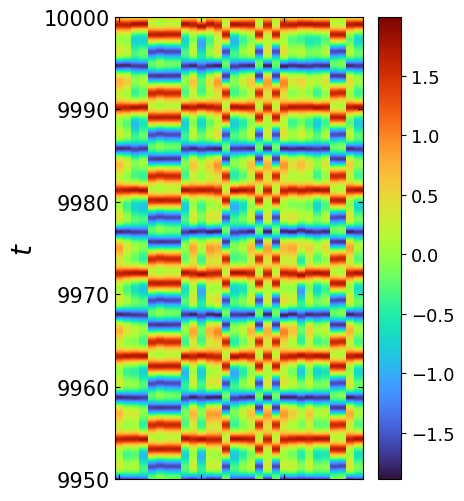

In [17]:
t_init = 9950
t_final = 10000

fig, (ax01) = plt.subplots(1, 1, figsize=(4, 6))
cax_01 = ax01.pcolormesh(x_grid, t_light, U_light, cmap="turbo", shading='auto')
cbar = fig.colorbar(cax_01)
cbar.ax.tick_params(labelsize=13)
ax01.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax01.set_ylabel("$t$", fontsize=20)
ax01.set_ylim(t_init, t_final)

figure_dir = "C:/Users/Rafa/PycharmProjects/LENL_simulations/00_projects/network_chimeras/simulations/figures"
plt.savefig(figure_dir + '/fig_chimeras.png', dpi=300)

(9950.0, 10000.0)

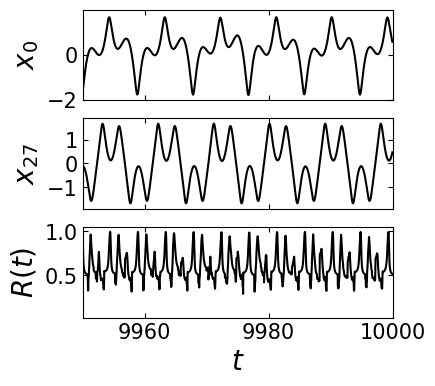

In [18]:
fig, (ax01, ax02, ax03) = plt.subplots(3, 1, figsize=(4, 4))
ax01.plot(t_light, U_light[:, 0], color="k")
ax01.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax01.set_ylabel("$x_0$", fontsize=20)
ax01.set_xlim(t_init, t_final)

ax02.plot(t_light, U_light[:, 27], color="k")
ax02.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax02.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax02.set_ylabel(f"$x_{{{27}}}$", fontsize=20)
ax02.set_xlim(t_init, t_final)

ax03.plot(t_light[:-1], R, color="k")
ax03.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax03.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax03.set_xlabel("$t$", fontsize=20)
ax03.set_ylabel("$R(t)$", fontsize=20)
ax03.set_xlim(t_init, t_final)

(9950.0, 10000.0)

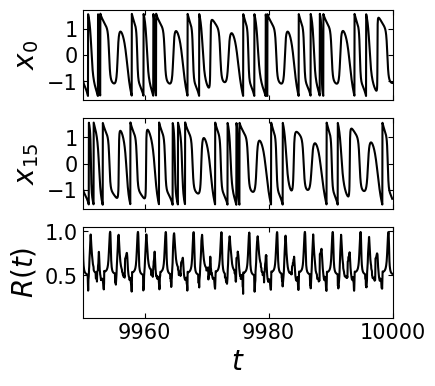

In [19]:
fig, (ax01, ax02, ax03) = plt.subplots(3, 1, figsize=(4, 4))
ax01.plot(t_light[:-1], phase_light[:, 0], color="k")
ax01.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax01.set_ylabel("$x_0$", fontsize=20)
ax01.set_xlim(t_init, t_final)

ax02.plot(t_light[:-1], phase_light[:, 2], color="k")
ax02.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax02.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax02.set_ylabel(f"$x_{{{N_nodes // 2}}}$", fontsize=20)
ax02.set_xlim(t_init, t_final)

ax03.plot(t_light[:-1], R, color="k")
ax03.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax03.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=True)
ax03.set_xlabel("$t$", fontsize=20)
ax03.set_ylabel("$R(t)$", fontsize=20)
ax03.set_xlim(t_init, t_final)

8000.0
10000.0


Text(0, 0.5, '$\\sigma$')

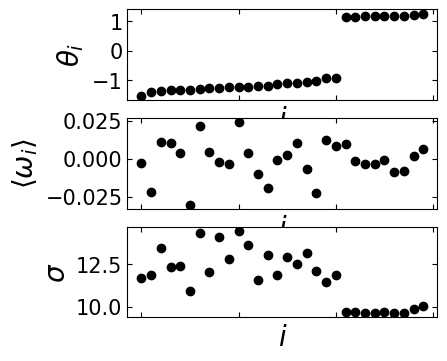

In [24]:
from scipy import integrate
i_0 = np.argmin(np.abs(t_grid - 8000))
i_f = np.argmin(np.abs(t_grid - t_final))

print(t_grid[i_0])
print(t_grid[i_f])

omega_average = integrate.simpson(np.diff(phase_light, axis=0)[i_0:] / dt, t_grid[i_0:i_f - 2], axis=0) / (t_grid[i_f - 2] - t_grid[i_0])
sigma2 = integrate.simpson(((np.diff(phase_light, axis=0)[i_0:] / dt) - omega_average) ** 2, t_grid[i_0:i_f - 2], axis=0) / (t_grid[i_f - 2] - t_grid[i_0])

fig, (ax01, ax02, ax03) = plt.subplots(3, 1, figsize=(4, 4))
args = np.argsort(phase_light[-1, :])
ax01.scatter(x_grid, np.sort(phase_light[-1, args]), color="k")
ax01.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax01.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax01.set_xlabel("$i$", fontsize=20)
ax01.set_ylabel("$\\theta_i$", fontsize=20)

ax02.scatter(x_grid, omega_average[args], color="k")
ax02.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax02.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax02.set_xlabel("$i$", fontsize=20)
ax02.set_ylabel("$\\langle \\omega_i \\rangle$", fontsize=20)

ax03.scatter(x_grid, np.sqrt(sigma2[args]), color="k")
ax03.tick_params(axis="y", direction="in", labelsize=15, left=True, right=True, labelleft=True, labelright=False)
ax03.tick_params(axis="x", direction="in", labelsize=15, top=True, bottom=True, labeltop=False, labelbottom=False)
ax03.set_xlabel("$i$", fontsize=20)
ax03.set_ylabel("$\\sigma$", fontsize=20)

In [153]:
T_00 = int(0.50 * Nt)
T_01 = int(0.85 * Nt)
T_02 = int(0.90 * Nt)
T_03 = int(0.95 * Nt)
T_04 = int(1.00 * Nt)

In [134]:
I = np.eye(2 * Nx)
lyap_01 = []
N_condit = int(2 * Nx)
U_init = np.random.rand(2 * Nx, N_condit) - 0.5
Q, R = np.linalg.qr(U_init)
dt = 1.0 * dt
for i in range(T_00, T_04 - 1):
    U_1 = U_light[i, :]
    U_2 = V_light[i, :]
    J = jacobians_FD(eq, [U_1, U_2], t_grid, x_grid, [0], parameters_np, operators)
    Q_new = time_propagator("I_Jdt_RK4", I, J, Q, dt)
    Q, R = np.linalg.qr(Q_new)
    Q = Q
    lyap_01.append(np.log(np.absolute(R.diagonal())) / dt)
lyap_01 = np.array(lyap_01)
lyap_mean_01 = []
average_Nt_i = T_00
for i in range(N_condit):
    lyap_mean_01.append(np.sum(lyap_01[:, i]))
    #plt.plot(lyap_01[:, i])
lyap_mean_01 = np.array(lyap_mean_01) / len(lyap_01[:, 0])
#plt.tight_layout()
#plt.savefig('lyap_espectrum.png', dpi=300)
#plt.show()

In [157]:
lyap_02 = []
Q, R = np.linalg.qr(U_init)
dt = 1.0 * dt
for i in range(T_01, T_04 - 1):
    U_1 = U_light[i, :]
    U_2 = V_light[i, :]
    J = jacobians_FD(eq, [U_1, U_2], t_grid, x_grid, [0], parameters_np, operators)
    Q_new = time_propagator("I_Jdt_RK4", I, J, Q, dt)
    Q, R = np.linalg.qr(Q_new)
    Q = Q
    lyap_02.append(np.log(np.absolute(R.diagonal())) / dt)
lyap_02 = np.array(lyap_02)
lyap_mean_02 = []
average_Nt_i = T_01
for i in range(N_condit):
    lyap_mean_02.append(np.sum(lyap_02[average_Nt_i:-1, i]))
lyap_mean_02 = np.array(lyap_mean_02) / (len(lyap_02[average_Nt_i:-1,0]))

In [156]:
lyap_03 = []
Q, R = np.linalg.qr(U_init)
dt = 1.0 * dt
for i in range(T_02, T_04 - 1):
    U_1 = U_light[i, :]
    U_2 = V_light[i, :]
    J = jacobians_FD(eq, [U_1, U_2], t_grid, x_grid, [0], parameters_np, operators)
    Q_new = time_propagator("I_Jdt_RK4", I, J, Q, dt)
    Q, R = np.linalg.qr(Q_new)
    Q = Q
    lyap_03.append(np.log(np.absolute(R.diagonal())) / dt)
lyap_03 = np.array(lyap_03)
lyap_mean_03 = []
average_Nt_i = T_02
for i in range(N_condit):
    lyap_mean_03.append(np.sum(lyap_03[average_Nt_i:-1, i]))
lyap_mean_03 = np.array(lyap_mean_03) / len(lyap_03[average_Nt_i:-1, 0])

In [163]:
lyap_04 = []
Q, R = np.linalg.qr(U_init)
dt = 1.0 * dt
for i in range(T_03, T_04 - 1):
    U_1 = U_light[i, :]
    U_2 = V_light[i, :]
    J = jacobians_FD(eq, [U_1, U_2], t_grid, x_grid, [0], parameters_np, operators)
    Q_new = time_propagator("I_Jdt_RK4", I, J, Q, dt)
    Q, R = np.linalg.qr(Q_new)
    Q = Q
    lyap_04.append(np.log(np.absolute(R.diagonal())) / dt)
lyap_04 = np.array(lyap_04)
lyap_mean_04 = []
average_Nt_i = int(0.0 * Nt)
for i in range(N_condit):
    lyap_mean_04.append(np.sum(lyap_04[average_Nt_i:-1, i]))
lyap_mean_04 = np.array(lyap_mean_04) / len(lyap_04[average_Nt_i:-1, 0])

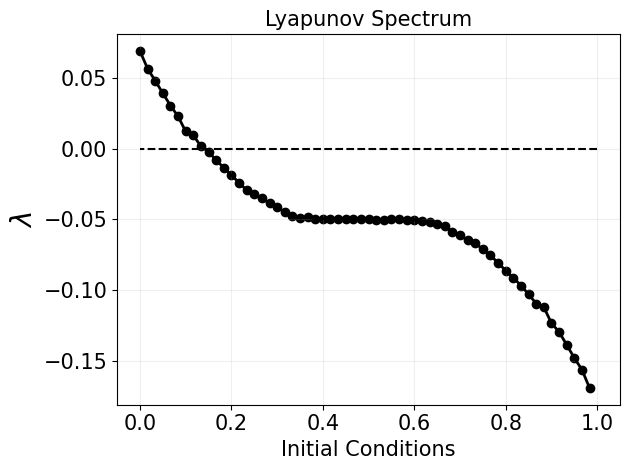

In [135]:
x = np.arange(N_condit) / N_condit
plt.plot(x, lyap_mean_01, c="k", linewidth=2)
plt.scatter(x, lyap_mean_01, color="k")
#plt.plot(x, lyap_mean_02, c="r", linewidth=2)
#plt.scatter(x, lyap_mean_02, color="r")
#plt.plot(x, lyap_mean_03, c="g", linewidth=2)
#plt.scatter(x, lyap_mean_03, color="g")
#plt.plot(x, lyap_mean_04, c="b", linewidth=2)
#plt.scatter(x, lyap_mean_04, color="b")
plt.hlines(0, 1, 0, color="k", linestyle="--")
plt.title("Lyapunov Spectrum", size='15')
plt.xlabel('Initial Conditions', size='15')
plt.xticks(fontsize=15)
plt.ylabel('$\\lambda$', size='20')
plt.yticks(fontsize=15)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('lyap_espectrums.png', dpi=300)
plt.show()

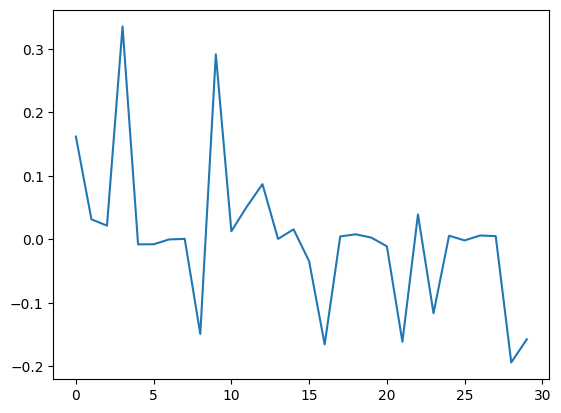

In [126]:
plt.plot(x_grid, Q[:30, 16])
plt.show()